In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords 
from numpy import array 
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten,merge
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.layers import Input,RepeatVector,Permute,Multiply,Lambda,Bidirectional
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [3]:
df = pd.read_csv('reviews.csv')
df.isnull().values.any() # checks if data file have any null values
df.head()

,reviews,sentiment
0,"Well, you'd better if you plan on sitting thro...",0
1,Moonwalker is a Fantasy Music film staring Mic...,1
2,I bought this video on a throw-out table at th...,0
3,Since the last horrid Astérix film and the fac...,1
4,"I grew up with the Abbott and Costello movies,...",1


In [4]:
def preprocess(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
  text = re.sub('[\W]+', ' ', text.lower()) +\
      ' '.join(emoticons).replace('-', '')
  return text

In [5]:
X = []
sentences = list(df['reviews'])
for sen in sentences:
    X.append(preprocess(sen))
y = df['sentiment']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[0])
print(len(X_train[0]))
print(len(X_test[0]))

[85, 21, 261, 30, 4, 1, 1573, 826, 10, 15, 4822, 424, 7, 6, 90, 424, 1, 586, 6, 1337, 2, 424, 1, 114, 6, 1420, 2221, 192, 10, 6, 3, 468, 4, 34, 412, 1254, 492, 2, 45, 11, 6, 125, 148, 91, 1800, 93, 20, 79, 365, 10, 28, 39, 25, 191, 49, 1427, 5, 10, 15, 5, 52, 73, 16, 1, 16, 28, 1, 563, 33, 3, 93, 1806, 1453, 186, 6, 53, 951, 2, 2417, 1, 564, 922, 1, 273, 6, 3, 997, 37, 1, 713, 4561, 4, 89, 98, 2, 236, 18, 23, 222, 1, 925, 6, 47, 90, 1, 19, 16, 68, 1, 1193, 4, 10, 19, 96, 27, 221, 3, 72, 127, 297, 4900, 1, 271, 5, 94, 7, 52, 818, 14, 3, 1095, 192, 45, 20, 50, 10, 2964, 1, 925, 6, 81, 632, 30, 616, 8, 3, 646, 2638, 1338, 41, 1035, 5, 29, 3047, 177, 7, 4, 3857, 51, 149, 1683, 125, 1574, 5, 77, 48, 4, 1, 159, 2, 20, 203, 365, 10, 19, 14, 72, 14, 9, 119]
180
244


In [10]:
# padding process 
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [12]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
embedding_matrix.shape

(94562, 300)

In [14]:
units=200
vocab_size = embedding_matrix.shape[0]
embedding_size = embedding_matrix.shape[1]


_input = Input(shape=[maxlen], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_size,
        input_length=maxlen,
        trainable=False,
        mask_zero=False,
        weights=[embedding_matrix]
    )(_input)

activations = LSTM(units, return_sequences=True)(embedded)
activations = Dropout(0.3)(activations)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

# apply the attention
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)
sent_representation = Dropout(0.4)(sent_representation)

probabilities = Dense(1, activation='sigmoid')(sent_representation)

model = Sequential()
checkpoint = ModelCheckpoint(filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train, epochs=6, batch_size=64, validation_data = (X_test,y_test))

ValueError: Please provide as model targets either a single array or a list of arrays. You passed: y=39087    1
30893    1
45278    1
16398    1
13653    1
        ..
11284    0
44732    0
38158    1
860      1
15795    0
Name: sentiment, Length: 40000, dtype: int64

In [32]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
#val_acc = history.history['acc'][4]

Test Score: 0.3766204190015793
Test Accuracy: 0.8553000092506409


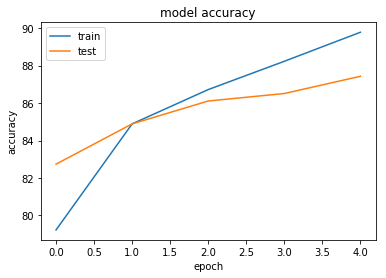

In [33]:
import matplotlib.pyplot as plt

plt.plot([79.23,84.89,86.72,88.23,89.78])
plt.plot([82.74,84.89,86.11,86.51,87.43])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


In [1]:
instance = X[57]
print(instance)
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

NameError: name 'X' is not defined

In [38]:
# instance = tokenizer.texts_to_sequences(instance)

# flat_list = []
# for sublist in instance:
#     for item in sublist:
#         flat_list.append(item)

# flat_list = [flat_list]

# instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict_classes(instance)

AttributeError: 'Model' object has no attribute 'predict_classes'

In [39]:
y[0]

0